In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [6]:
%run NCoinDP_functions.ipynb

In [7]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev) 

2.1.2+cu121
True
NVIDIA A10


In [8]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from DNN_module import Net
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


# Default : cuda
torch.set_default_device('cuda')

# Number of train and validation data
L_train = 100000
L_val   =  50000

# Define the batch size
BATCH_SIZE = 64

# Number of Epochs
N_EPOCHS = 250
    
# Number of Simulations
sims = 50

# Number of observation
nums = [500, 1000, 3000]

for num in nums:
    tmp = "../depot_hyun/hyun/syn_data/OU_sim_n" + str(num) + ".pt"
    tmp = torch.load(tmp)

    for sim in range(sims):
        # Data import
        [X, Y] = tmp
        X = X.to(device)
        Y = Y.to(device)

        torch.manual_seed(1000 + sim)
        indexes = torch.randperm(L_train + L_val)

        # Divide Data
        X_train = X[indexes[0:L_train]]
        Y_train = Y[indexes[0:L_train]]

        X_val = X[indexes[L_train:(L_train + L_val)]]
        Y_val = Y[indexes[L_train:(L_train + L_val)]]

        # Use torch.utils.data to create a DataLoader that will take care of creating batches
        dataset = TensorDataset(X_train, Y_train)
        dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))

        # Get the dataset size for printing (it is equal to N_SAMPLES)
        dataset_size = len(dataloader.dataset)

        # Define the input and output dimensions
        D_in, D_out = X_train.size()[1], Y_train.size()[1]

        # Create an instance of the Net class with specified dimensions
        net = Net(D_in = D_in, D_out = D_out)

        # Model name
        model_save_name = 'nets/OU/n_'+str(num)+"_"+str(sim)+'.pt'
        path = F"./{model_save_name}"

        # The nn package also contains definitions of popular loss functions; in this case we will use Mean Squared Error (MSE) as our loss function.
        loss_fn = torch.nn.MSELoss(reduction='sum')
        learning_rate = 1e-4
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

        train_error_plt = []
        val_error_plt = []

        torch.manual_seed(2000 + sim)

        # Loop over epochs
        for epoch in range(N_EPOCHS):
            for id_batch, (x_batch, y_batch) in enumerate(dataloader):
                y_batch_pred = net(x_batch)
                loss = loss_fn(y_batch_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if epoch % 50 ==0 and id_batch % 100 == 0:
                    loss, current = loss.item(), (id_batch + 1)* len(x_batch)
                    print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

            with torch.no_grad():
                   net.eval()
                   theta_pred_train = net(X_train)
                   train_loss = loss_fn(theta_pred_train,Y_train) / L_train
                   train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

                   theta_pred_val = net(X_val)
                   val_loss = loss_fn(Y_val, theta_pred_val) / L_val
                   val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

            if epoch % 10 ==0:
                print(f"Epoch {epoch + 1}\n-------------------------------")
                print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
                print("learning rate: ", learning_rate, ", num: ", num, ", sim: ", sim)

            ## Choose Best Model
            if val_error_plt[epoch] == np.min(val_error_plt):
                 best=epoch
                 torch.save(net.state_dict(), path)

            if epoch % 100 ==99:
                net.load_state_dict(torch.load(path))
                learning_rate = max(learning_rate * 1e-1, 1e-9)


train_loss: 15.248981  [   64/100000]
train_loss: 7.694872  [ 6464/100000]
train_loss: 5.519223  [12864/100000]
train_loss: 3.563014  [19264/100000]
train_loss: 1.518929  [25664/100000]
train_loss: 1.169680  [32064/100000]
train_loss: 0.994654  [38464/100000]
train_loss: 0.728587  [44864/100000]
train_loss: 1.468393  [51264/100000]
train_loss: 0.820911  [57664/100000]
train_loss: 0.682344  [64064/100000]
train_loss: 0.753097  [70464/100000]
train_loss: 0.613905  [76864/100000]
train_loss: 0.622780  [83264/100000]
train_loss: 0.629473  [89664/100000]
train_loss: 0.536815  [96064/100000]
Epoch 1
-------------------------------
train_loss 0.697133 val_loss 0.698923
learning rate:  0.0001 , num:  500 , sim:  0
Epoch 11
-------------------------------
train_loss 0.571494 val_loss 0.572731
learning rate:  0.0001 , num:  500 , sim:  0
Epoch 21
-------------------------------
train_loss 0.558529 val_loss 0.562025
learning rate:  0.0001 , num:  500 , sim:  0
Epoch 31
---------------------------

KeyboardInterrupt: 

In [ ]:
print(path)

In [ ]:
#net.load_state_dict(torch.load("./OU_0.pt"))
net.load_state_dict(torch.load(path))

torch.set_default_device('cpu')
print(np.min(val_error_plt))
print(np.argmin(val_error_plt))
plt.plot(np.arange(N_EPOCHS), train_error_plt, color = "r")
plt.plot(np.arange(N_EPOCHS), val_error_plt)
plt.legend(["train", "validation"], loc ="upper right")

In [ ]:
net = net.to(torch.device('cpu'))

In [ ]:
# Generate the simulation data to get the mean and standard deviation of estimated parameter
sim = 3000
torch.manual_seed(401)

# Generating times
n = num
delta = 1/52
obtime = np.arange(0,n+1)/n * n * delta

param1 = torch.Tensor([3, 2, 1])
param2 = torch.Tensor([4,1.5,1.5])
param3 = torch.Tensor([2,1.1,1.9])

y0_sim1 = torch.normal(torch.ones(sim) * param1[1], torch.ones(sim) * ((param1[2]/ (2* param1[0]) )**(1/2) )) # (3,2,1)
y0_sim2 = torch.normal(torch.ones(sim) * param2[1], torch.ones(sim) * ((param2[2]/ (2* param2[0]) )**(1/2) )) # (4, 1.5, 1.5)
y0_sim3 = torch.normal(torch.ones(sim) * param3[1], torch.ones(sim) * ((param3[2]/ (2* param3[0]) )**(1/2) )) # (2, 1.1, 1.9)

sim_data1 = OU_simul_sample(sim, obtime, y0_sim1, param1[0] * torch.ones(sim), param1[1] * torch.ones(sim), torch.sqrt(param1[2]) * torch.ones(sim))
sim_data2 = OU_simul_sample(sim, obtime, y0_sim2, param2[0] * torch.ones(sim), param2[1] * torch.ones(sim), torch.sqrt(param2[2]) * torch.ones(sim))
sim_data3 = OU_simul_sample(sim, obtime, y0_sim3, param3[0] * torch.ones(sim), param3[1] * torch.ones(sim), torch.sqrt(param3[2]) * torch.ones(sim))

#sim_data1_mom = moment_L(sim_data1)
#sim_data2_mom = moment_L(sim_data2)
#sim_data3_mom = moment_L(sim_data3)

sim_data1_mom = OU_summary(sim_data1)
sim_data2_mom = OU_summary(sim_data2)
sim_data3_mom = OU_summary(sim_data3)

In [7]:
net.eval()
print(torch.mean(net(sim_data1_mom),0),torch.median(net(sim_data1_mom),0),torch.std(net(sim_data1_mom),0)) # (3,2,1)
print(torch.mean(net(sim_data2_mom),0),torch.median(net(sim_data2_mom),0),torch.std(net(sim_data2_mom),0)) # (4, 1.5, 1.5)
print(torch.mean(net(sim_data3_mom),0),torch.median(net(sim_data3_mom),0),torch.std(net(sim_data3_mom),0)) # (2, 1.1, 1.9#)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [63]:
print(torch.sqrt((torch.sum(torch.square(net(sim_data1_mom)[:,0] - param1[0])) +torch.sum(torch.square(net(sim_data1_mom)[:,1] - param1[1])) +torch.sum(torch.square(net(sim_data1_mom)[:,2] - param1[2]))) /sim ) )
print(torch.sqrt((torch.sum(torch.square(net(sim_data2_mom)[:,0] - param2[0])) +torch.sum(torch.square(net(sim_data2_mom)[:,1] - param2[1])) +torch.sum(torch.square(net(sim_data2_mom)[:,2] - param2[2])))/sim) )
print(torch.sqrt((torch.sum(torch.square(net(sim_data3_mom)[:,0] - param3[0])) +torch.sum(torch.square(net(sim_data3_mom)[:,1] - param3[1])) +torch.sum(torch.square(net(sim_data3_mom)[:,2] - param3[2])))/sim))

tensor(0.6429, grad_fn=<SqrtBackward0>)
tensor(0.5427, grad_fn=<SqrtBackward0>)
tensor(0.7397, grad_fn=<SqrtBackward0>)


In [49]:
X_test = X_val.to('cpu')
y_test = Y_val.to('cpu')

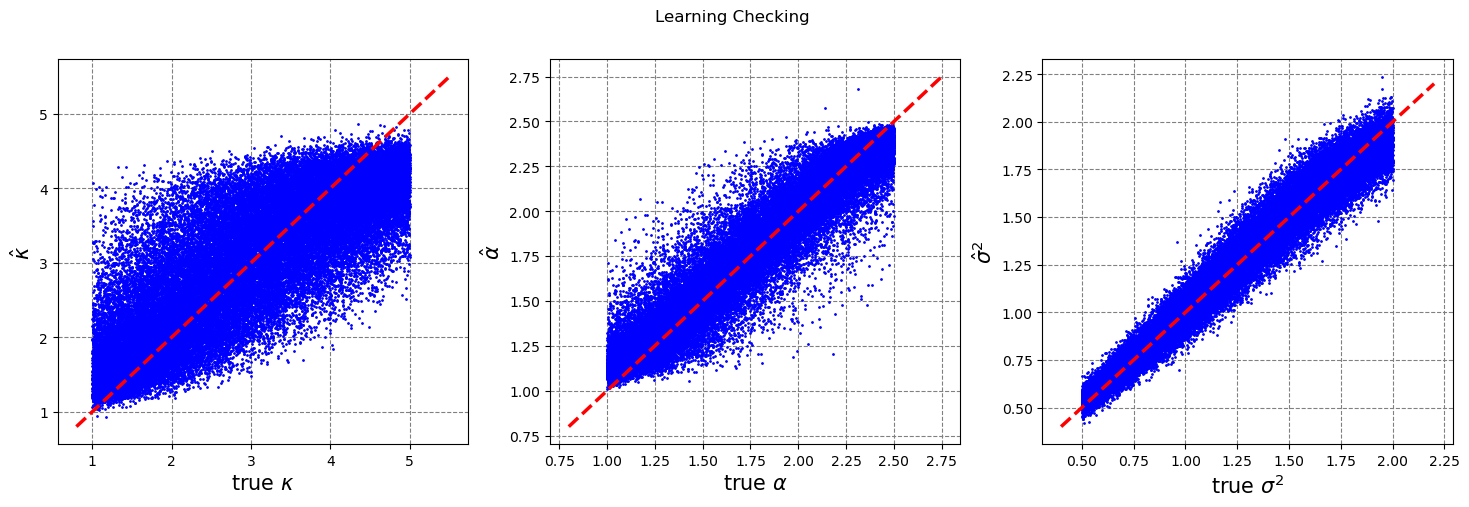

In [50]:
with torch.no_grad():
  net.eval()
  tmp1 = net(X_test.to('cpu'))[:,0]
  tmp2 = net(X_test.to('cpu'))[:,1]
  tmp3 = net(X_test.to('cpu'))[:,2]

  tmp1 = tmp1.detach().cpu().numpy().tolist()
  tmp2 = tmp2.detach().cpu().numpy().tolist()
  tmp3 = tmp3.detach().cpu().numpy().tolist()

mu_range = [1,5]
theta_range = [1,2.5]
sigma2_range = [0.5, 2]
# Plot for model checking
lim1 = [mu_range[0] * 0.8, mu_range[1] * 1.1]
lim2 = [theta_range[0] * 0.8, theta_range[1] * 1.1]
lim3 = [sigma2_range[0] * 0.8, sigma2_range[1] * 1.1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle('Learning Checking')

ax1.scatter(y_test[:,0], tmp1, marker='o', color='b', s = 1)
ax1.set_xlabel('true $\kappa$', fontsize=15)
ax1.set_ylabel('$\hat{\kappa}$', fontsize=15)
ax1.plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')

ax2.scatter(y_test[:,1], tmp2, marker='o', color='b', s = 1)
ax2.set_xlabel(r'true $\alpha$', fontsize=15 )
ax2.set_ylabel(r'$\hat{\alpha}$', fontsize=15)
ax2.plot(np.linspace(lim2[0], lim2[1], 1000), np.linspace(lim2[0], lim2[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='dashed')

ax3.scatter(y_test[:,2], tmp3, marker='o', color='b', s = 1)
ax3.set_xlabel('true $\sigma^2$', fontsize=15)
ax3.set_ylabel('$\hat{\sigma}^2$', fontsize=15)
ax3.plot(np.linspace(lim3[0], lim3[1], 1000), np.linspace(lim3[0], lim3[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax3.set_axisbelow(True)
ax3.grid(color='gray', linestyle='dashed')

plt.show()